In [5]:
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
class Fuzzy_controller:
    def __init__(self,params):
        self.antecedents = {}
        self.consequents = {}
        self.params = params
        self.default_inputs = {}
    def define_antecedents(self):
        pass
    def define_consequents(self):
        #// define consequents
        range_value = np.arange(0, 1, .01)
        early_diff = ctrl.Consequent(range_value, 'early_diff')
        late_diff = ctrl.Consequent(range_value, 'late_diff')
        
        #// define membership functions
        sigma = .05
        diff_intervals = [0,self.params['early_diff_L'],.5,self.params['early_diff_H'],self.params['early_diff_VH'], 1]
        early_diff['Z']=fuzz.gaussmf(range_value, diff_intervals[0], sigma)
        early_diff['L']=fuzz.gaussmf(range_value, diff_intervals[1], sigma)
        early_diff['M']=fuzz.gaussmf(range_value, diff_intervals[2], sigma)
        early_diff['H']=fuzz.gaussmf(range_value, diff_intervals[3], sigma)
        early_diff['VH']=fuzz.gaussmf(range_value, diff_intervals[4], sigma)
        early_diff['EH']=fuzz.gaussmf(range_value, diff_intervals[5], sigma)


        diff_intervals = [0,self.params['late_diff_L'],.5,self.params['late_diff_H'], 1]
        late_diff['Z']=fuzz.gaussmf(range_value, diff_intervals[0], sigma)
        late_diff['L']=fuzz.gaussmf(range_value, diff_intervals[1], sigma)
        late_diff['M']=fuzz.gaussmf(range_value, diff_intervals[2], sigma)
        late_diff['H']=fuzz.gaussmf(range_value, diff_intervals[3], sigma)
        late_diff['VH']=fuzz.gaussmf(range_value, diff_intervals[4], sigma)
#         early_diff.view()
        #// Store
        self.consequents['early_diff'] = early_diff
        self.consequents['late_diff'] = late_diff
    def define_rules(self):
        pass
    def forward(self,inputs):
        # print('inputs: {}'.format(inputs))
        for key,value in inputs.items():
            self.default_inputs[key] = value

        for key,value in self.default_inputs.items():
            self.controler.input[key] = value
        self.controler.compute()
        for key,item in self.consequents.items():
            item.view(sim=self.controler)
        outputs = self.controler.output
        # print('outputs: {}'.format(outputs))
        return outputs
class Fuzzy_IL8_IL1b(Fuzzy_controller):
    def __init__(self,params):
        super().__init__(params)
        self.define_antecedents()
        self.define_consequents()
        self.define_rules()
        self.default_inputs = {'IL8':0,'IL1b':0}

    def define_antecedents(self):
        #// define antecedents
        intervals = [0,self.params['IL8_M'],100]
        IL8 = ctrl.Antecedent(np.arange(intervals[0], intervals[-1], .005), 'IL8')
        # print(IL10_intervals)
        IL8['Neg'] = fuzz.trimf(IL8.universe, [intervals[0], intervals[0],intervals[1]])
        IL8['Med'] = fuzz.trimf(IL8.universe, [intervals[0], intervals[1], intervals[2]])
        IL8['High'] = fuzz.trimf(IL8.universe, [intervals[1], intervals[2], intervals[2]])
        IL8['NNeg'] = fuzz.trapmf(IL8.universe, [intervals[0], intervals[1],intervals[-1],intervals[-1]])

        #// store
        self.antecedents['IL8']=IL8

        intervals = [0,10,self.params['IL1b_H'],200]
        IL1b = ctrl.Antecedent(np.arange(intervals[0], intervals[-1], .005), 'IL1b')
        IL1b['Neg'] = fuzz.trimf(IL1b.universe, [intervals[0], intervals[0],intervals[1]])
        IL1b['Stim'] = fuzz.trimf(IL1b.universe, [intervals[0], intervals[1], intervals[2]])
        IL1b['High'] = fuzz.trapmf(IL1b.universe, [intervals[1], intervals[2], intervals[3],intervals[3]])
        IL1b['NNeg'] = fuzz.trapmf(IL1b.universe, [intervals[0], intervals[1],intervals[-1],intervals[-1]])


        self.antecedents['IL1b']=IL1b

    def define_rules(self):
        #// rules
        IL8 = self.antecedents['IL8']
        IL1b = self.antecedents['IL1b']
        early_diff = self.consequents['early_diff']
        late_diff = self.consequents['late_diff']
        early_diff_rules = [
            # only IL8
            ctrl.Rule(IL1b['Neg'] & IL8['Neg'] , early_diff['M']),
            ctrl.Rule(IL1b['Neg'] & IL8['Med'] , early_diff['VH']),
            ctrl.Rule(IL1b['Neg'] & IL8['High'] , early_diff['EH']),
            # only IL1b
            ctrl.Rule(IL1b['Stim'] & IL8['Neg'] , early_diff['H']),
            ctrl.Rule(IL1b['High'] & IL8['Neg'] , early_diff['M']),
            # combined
            ctrl.Rule(IL1b['NNeg'] & IL8['NNeg'] , early_diff['VH'])            

        ]
        rules = early_diff_rules
        self.controler = ctrl.ControlSystemSimulation(ctrl.ControlSystem(rules))


/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure

/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure

/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure

/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



OrderedDict([('early_diff', 0.9533719101121437)])

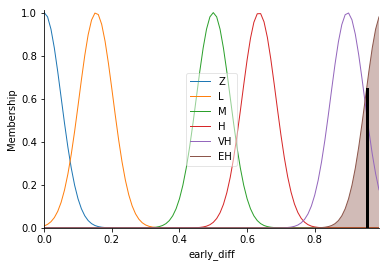

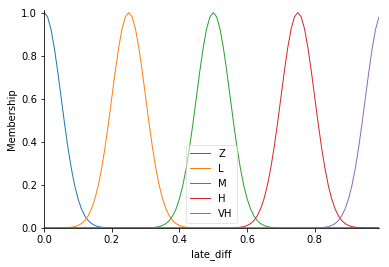

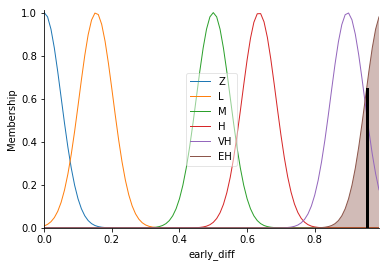

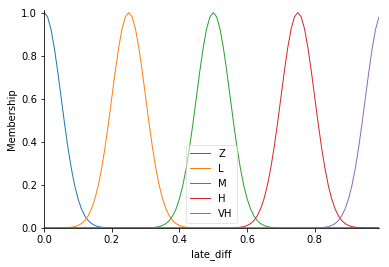

In [9]:
from observations import observations
from MSC_osteogenesis import all_params

with open('inferred_params.json') as file:
    inferred_params = json.load(file)
    
for key,value in inferred_params.items():
    all_params[key] = value
obj = Fuzzy_IL8_IL1b(all_params)
obj.forward(inputs={'IL8':100})
obj.forward(inputs={'IL8':100})